In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import math
import random
import swmmio
import pyswmm
from pyswmm import Simulation,Subcatchments
import math
import pickle
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point, box
import tifffile
import rasterio
import numpy as np
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
from rasterio.transform import from_origin
from rasterio.enums import Resampling
import os   
import re
import argparse
import random
import torch
from systems_pbc import *
import torch.backends.cudnn as cudnn
from utils import *
from visualize import *
import matplotlib.pyplot as plt
from models import FNN3d
from train_utils import Adam
from tqdm import tqdm
from train_utils.losses import GeoPC_loss
import matplotlib.image as pm
from matplotlib.colors import ListedColormap
import torch.nn as nn
# from mpl_toolkits.basemap import Basemap
import tifffile
from data_ import utils
import scipy.ndimage
import torch.nn.functional as F
import boundary
import boundary_gt
from PIL import Image
from pyMesh import visualize2D, setAxisLabel
import train_utils.tensorboard as tb
from AWL import AutomaticWeightedLoss
import torch.nn.functional as F
from hydraulics import saint_venant
from scipy import interpolate
# from skimage.transform import resize
from train_utils.losses import *
from torch.utils.data import DataLoader
from pyMesh import visualize2D
import imageio
import io
import tifffile as tiff
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
os.environ['CUDA_LAUNCH_BLOCKING'] = "5"
gpu_ids = [0]
output_device = gpu_ids[0]
Root_path='/home/sirui/INNOMAUS/'##################### please change the path to your local path !!! ###################
################
runoff_txt_path = Root_path+"data/runofftxt"
inp_file =  Root_path+'data/Berlin_I.inp'
scale=12
################
# Arguments
################
class Args:
    def __init__(self):
        # Basic configuration
        self.loss_style = 'mean'  # Loss for the network (MSE vs. summing)
        self.visualize = True  # Visualize the solution
        self.save_model = True  # Save the model for analysis later

        # PINO_model configuration
        self.layers = [16, 24, 24, 32, 32]  # Dimensions/layers of the NN
        self.modes1 = [32, 32, 32, 32]  # Modes for first dimension
        self.modes2 = [32, 32, 32, 32]  # Modes for second dimension
        self.modes3 = [8, 8, 8, 8]  # Modes for third dimension
        self.fc_dim = 128  # Fully connected layer dimension
        self.epochs = 15000  # Number of epochs
        self.activation = 'gelu'  # Activation function to use in the network

        # Training configuration
        self.base_lr = 0.001  # Learning rate
        self.milestones = [500, 1000, 2000, 3000, 4000, 5000]  # Milestones for learning rate scheduler
        self.scheduler_gamma = 0.5  # Gamma for learning rate scheduler
        self.theta = 0.7  # q-centered weighting. [0,1]

    def __str__(self):
        return (f'Args(loss_style={self.loss_style}, visualize={self.visualize}, save_model={self.save_model}, '
                f'layers={self.layers}, modes1={self.modes1}, modes2={self.modes2}, modes3={self.modes3}, '
                f'fc_dim={self.fc_dim}, epochs={self.epochs}, activation={self.activation}, '
                f'base_lr={self.base_lr}, milestones={self.milestones}, scheduler_gamma={self.scheduler_gamma}, '
                f'theta={self.theta})')

# Example of how to use the Args class:
args = Args()

# Accessing an attribute
print("Layers:", args.layers)

# Print all arguments
print(args)

import sys

# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(device)
else:
    device = torch.device('cpu')
    print(device)
#device = torch.device('cpu')
#output_device=device
print(device)

Layers: [16, 24, 24, 32, 32]
Args(loss_style=mean, visualize=True, save_model=True, layers=[16, 24, 24, 32, 32], modes1=[32, 32, 32, 32], modes2=[32, 32, 32, 32], modes3=[8, 8, 8, 8], fc_dim=128, epochs=15000, activation=gelu, base_lr=0.001, milestones=[500, 1000, 2000, 3000, 4000, 5000], scheduler_gamma=0.5, theta=0.7)
cuda
cuda


In [2]:
def sum_data_5min(data):
    t=len(data)
    timestep = 10
    output = np.zeros((math.ceil(t/timestep)))
    for i in range(0,math.ceil(t/timestep)):
        output[i] = np.sum(data[i*timestep:(i+1)*timestep])
    return output
def rasterize(path,subs,extent):
  data = {}
  for file in os.listdir(path):
    if file.endswith(".txt"):
        path_txt = os.path.join(path, file)
        match = re.search(r'(\d+mm)', file)
        if match:
            name = match.group(1)
        data_txt = []
        data_txt_sum = []
        for point_id in subs.index:
            data_txt.append(np.loadtxt(path_txt, skiprows=1,usecols=point_id+1))
            data_txt_sum.append(sum_data_5min(data_txt[point_id]))
        data_txt = np.array(data_txt)
        data_txt_sum = np.array(data_txt_sum)[:,:25]
        print(data_txt_sum.shape)
        fig=plt.figure()
        ax = fig.add_subplot(111)
        ax.set_title('plots')
        ax.set_xlabel('Time')
        ax.set_ylabel('Runoff')
        for i in range(0,subs.shape[0]):
            ax.plot(data_txt_sum[i])
        plt.show()
        width = extent[2] - extent[0]-1
        height = extent[3] - extent[1]
        print(width,height)
        new_map = np.zeros((math.ceil(height),math.ceil(width),data_txt_sum.shape[1]))   
        points = subs['center_point']
        picxy = points.apply(lambda p: (p.x-extent[0], height-(p.y-extent[1])))
        new_map[picxy.apply(lambda p: math.ceil(p[1])), picxy.apply(lambda p: math.ceil(p[0]))] = data_txt_sum
        print(len(np.where(new_map[:,:,:]!=0)[0]),new_map.shape)
        data[name] = new_map
  return data
def process(runoff_txt_path,inp_file):
    extent1 =[391688.1352,5816723.5617,394900.3042,5819450.5491] 
    # Import the SWMM model
    Bln_1_model=swmmio.Model(inp_file)
    subs=Bln_1_model.subcatchments.dataframe
    # Reset the index to add the Name of the subcatchments as a column to the dataframe
    subs = subs.reset_index()
    # convert the coordinates to a polygon coordination that can be used by geopandas
    subs['geometry']=subs['coords'].apply(lambda coords: Polygon(coords))

    # Create a GeoDataFrame with the specified CRS
    subs = gpd.GeoDataFrame(subs, geometry='geometry', crs='EPSG:25833')

    # drop unnecessary data
    subs.drop(columns=['Raingage', 'Outlet', 'PercImperv', 'Width',
       'PercSlope', 'CurbLength', 'N-Imperv', 'N-Perv', 'S-Imperv', 'S-Perv',
       'PctZero', 'RouteTo', 'PctRouted', 
        'coords', 'Area'],inplace=True)

    # Create a new column with the center points of the polygons
    subs['center_point'] = subs['geometry'].centroid
    # Plot the GeoDataFrame
    ax = subs.plot()
    # Plot the center points on the same plot
    subs['center_point'].plot(ax=ax, color='red', markersize=10)
    extent2 = subs.total_bounds
    extent = [min(extent1[0],extent2[0]), min(extent1[1],extent2[1]), max(extent1[2],extent2[2]), max(extent1[3],extent2[3])]
    runoff=rasterize(runoff_txt_path,subs,extent1)
    return runoff

runoff=process(runoff_txt_path,inp_file)
folder_path='/home/sirui/INNOMAUS/runoff_ori/b_135mm/'
gt=np.zeros([2727, 3212, 25])
import re
for file_name in os.listdir(folder_path):
    if file_name.endswith('.tif'):
        file_path = os.path.join(folder_path, file_name)
        print(file_path)
        match = re.search(r'(\d+)\.tif$', file_name)
        if match:
            #print( match.group(1))
            current_time =int( match.group(1))
            i=int(current_time/300)
        gt[:,:,i]=tiff.imread(file_path)
a=maxpool_with_nearest_non_zero_torch(runoff['135mm'][:,:,10], 48)
b=maxpool_with_nearest_non_zero_torch(gt[:,:,10], 48)
plt.imshow(a)
plt.show()
plt.imshow(b)
plt.show()


#print(runoff.shape,gt.shape)
mse = F.mse_loss(torch.tensor(runoff['135mm'].reshape(-1)),torch.tensor( gt.reshape(-1)))
print(mse)
a=runoff['135mm']
b=gt
print("Non-zero values in matrix a:")
print(a[a != 0])

# Non-zero values in 'b'
print("\nNon-zero values in matrix b:")
print(b[b != 0])

In [3]:
############################
# Process data
###########################
def inter(array, size):
    h, w = array.shape
    new_h, new_w = np.floor_divide((h, w), size)
    x = np.linspace(0, w - 1, w)
    y = np.linspace(0, h - 1, h)
    new_x = np.linspace(0, w - 1, new_w)
    new_y = np.linspace(0, h - 1, new_h)
    f = interpolate.interp2d(x, y, array, kind='linear')
    array_down = f(new_x, new_y)
    # array_down = resize(array, (new_h, new_w), order=1, anti_aliasing=True)
    return array_down

def maxpool_with_nearest_non_zero_torch(array, downsample_factor):
    """
    Perform max pooling on the array using non-overlapping blocks of size `downsample_factor` x `downsample_factor`.
    Each downsampled pixel is assigned the maximum non-zero element from its corresponding block using PyTorch.
    """
    # Convert the numpy array to a PyTorch tensor
    array_tensor = torch.from_numpy(array).float()
    
    # Replace all zeros with a very small negative number to ignore them during max pooling
    array_tensor[array_tensor == 0] = -float('inf')
    
    # Reshape the array to 4D tensor: (batch_size=1, channels=1, height, width)
    array_tensor = array_tensor.unsqueeze(0).unsqueeze(0)
    
    # Apply 2D max pooling with kernel size and stride equal to the downsample factor
    pooled_tensor = torch.nn.functional.max_pool2d(array_tensor, kernel_size=downsample_factor, stride=downsample_factor)
    
    # Replace negative infinity back with zeros
    pooled_tensor[pooled_tensor == -float('inf')] = 0
    
    # Convert back to a NumPy array and remove the extra dimensions
    pooled_array = pooled_tensor.squeeze().numpy()
    
    return pooled_array

# Parameters
g = torch.tensor(9.80616, dtype=torch.float64)
imput_path_val = Root_path+'data/val'# Here we put 5 events for validation, it's also the location to put testing events

TILE_SIZE_X = 2000
TILE_SIZE_Y = 2000
ALLOWED_MASKED_PERCENTAGE = 0
MAX_TOPOGRAPHY_DIFFERENCE = 2000

In [4]:

def data(path, name, files,runoff):
    t0 = 25
    dt0 = 300
    t00, tfinal = 0, (t0) * dt0
    dx = 30.0 * 16
    # # data
    h_gt = []
    qx_gt = []
    qy_gt = []
    pre=[]
    for i in range(t00,tfinal,dt0):    
        current_time = str(i)
        print('current_time', current_time)
        path_h = os.path.join(path,'r2d_bln1_swmm_b_'+ '%s_%s'%(name,current_time)+'H'+".tif")
        path_u = os.path.join(path, 'r2d_bln1_swmm_b_'+ '%s_%s'%(name,current_time)+'U'+".tif")
        path_v = os.path.join(path, 'r2d_bln1_swmm_b_'+ '%s_%s'%(name,current_time)+'V'+".tif")
        pre_current = np.array(runoff[name][:,:,int(i/300)])
        pre_current = np.nan_to_num(pre_current, nan=0.0)
        pre_current = maxpool_with_nearest_non_zero_torch(pre_current, scale)
        print('pre_current', np.max(pre_current))
        pre_current = torch.from_numpy(pre_current)
        pre_current = pre_current.float()
        h_current = tiff.imread(path_h)
        h_current = np.array(h_current)
        h_current = np.nan_to_num(h_current, nan=0.0)
        h_current = inter(h_current, scale)
        print('h_current', np.max(h_current))
        h_current = torch.from_numpy(h_current)
        h_current = h_current.float()
        qx_current = tiff.imread(path_u)
        qx_current = np.array(qx_current)
        qx_current = np.nan_to_num(qx_current, nan=0.0)
        qx_current = inter(qx_current, scale)
        print('qx_current', np.max(qx_current))
        qx_current = torch.from_numpy(qx_current)
        qx_current = qx_current.float()
        qy_current = tiff.imread(path_v)
        qy_current = np.array(qy_current)
        qy_current = np.nan_to_num(qy_current, nan=0.0)
        qy_current = inter(qy_current, scale)
        print('qy_current', np.max(qy_current))
        qy_current = torch.from_numpy(qy_current)
        qy_current = qy_current.float()
        h_gt.append(h_current)
        qx_gt.append(qx_current)
        qy_gt.append(qy_current)
        pre.append(pre_current)
    h_gt = torch.stack(h_gt, 0)
    u_gt = torch.stack(qx_gt, 0)
    v_gt = torch.stack(qy_gt, 0)
    pre = torch.stack(pre, 0)
    print('len_supervised', h_gt.size())
            
    print('pre',pre.size(),len(np.where(pre!=0)[0]),pre[np.where(pre!=0)],max(pre[np.where(pre!=0)]))
    return h_gt, u_gt, v_gt, pre


In [5]:

class load_data():
    def __init__(self, runoff, path_gt):
        super().__init__()
        self.runoff = runoff
        self.imput_path_val=path_gt
        self.load()

    def load(self):
            runoff=self.runoff
            t0 = 25
            first_value = next(iter(runoff.values()))
            m = int(first_value.shape[0]/scale)
            n = int(first_value.shape[1]/scale)
            lmbdleft, lmbdright = 0, (m - 1)
            thtlower, thtupper = 0, (n - 1)
            dt = 300
            t00, tfinal = 0, (t0 - 1)
            t = np.linspace(t00, tfinal, t0)
            x = np.linspace(lmbdleft, lmbdright, m)
            y = np.linspace(thtlower, thtupper, n)
            data_star = np.hstack((x.flatten(), y.flatten(), t.flatten()))
            lb = data_star.min(0)
            ub = data_star.max(0)
            input_data_list = []
            h_gt_list = []
            u_gt_list = []
            v_gt_list = []
            z_list = []
            for root, directories, files in os.walk(self.imput_path_val):
                for subdirectory in directories:
                  path = os.path.join(root, subdirectory)
                  name = os.path.basename(path)
                  if name and name[0].isdigit():###
                    print(path)
                    print('Name', name)
                    h_gt, u_gt, v_gt, pre = data(path, name, files,self.runoff)
                    gridx = torch.from_numpy(x)
                    gridx = gridx.reshape(1, m, 1, 1, 1).repeat([1, 1, n, t0, 1])
                    gridy = torch.from_numpy(y)
                    gridy = gridy.reshape(1, 1, n, 1, 1).repeat([1, m, 1, t0, 1])
                    gridt = torch.from_numpy(t)
                    gridt = gridt.reshape(1, 1, 1, t0, 1).repeat([1, m, n, 1, 1])
                    gridpre = pre#torch.from_numpy(pre)
                    gridpre = gridpre.reshape(1, m, n, t0, 1)#.repeat([1, m, n, 1, 1])
                    h_init = h_gt[0, :, :]
                    h_init = h_init.reshape(1, m, n, 1, 1).repeat([1, 1, 1, t0, 1])
                    input_data = torch.cat((gridx, gridy, gridt, gridpre), dim=-1)
                    input_data = torch.cat((input_data, h_init.cpu()), dim=-1)
                    input_data = input_data.float()
                    h_gt = torch.unsqueeze(h_gt, dim=0)
                    u_gt = torch.unsqueeze(u_gt, dim=0)
                    v_gt = torch.unsqueeze(v_gt, dim=0)
                    input_data_list.append(input_data)
                    h_gt_list.append(h_gt)
                    u_gt_list.append(u_gt)
                    v_gt_list.append(v_gt)
            data_input = torch.cat(input_data_list, dim=0)
            gt_h = torch.cat(h_gt_list, dim=0)
            gt_u = torch.cat(u_gt_list, dim=0)
            gt_v = torch.cat(v_gt_list, dim=0)
            self.data_input = data_input
            self.gt_h = gt_h
            self.gt_u = gt_u
            self.gt_v = gt_v

    def __getitem__(self, idx):
        return self.data_input[idx], self.gt_h[idx], self.gt_u[idx], self.gt_v[idx]

    def __len__(self, ):
        return self.data_input.shape[0]


In [6]:
#eval
def generate_movie_2D(key, test_x, test_y, preds_y, plot_title='', field=0, val_cbar_index=-1, err_cbar_index=-1,
                      val_clim=None, err_clim=None, font_size=None, movie_dir='', movie_name='movie.gif',
                      frame_basename='movie', frame_ext='jpg', remove_frames=True):
    frame_files = []

    if movie_dir:
        os.makedirs(movie_dir, exist_ok=True)

    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})

    if len(preds_y.shape) == 4:
        Nsamples, Nx, Ny, Nt = preds_y.shape
        preds_y = preds_y.reshape(Nsamples, Nx, Ny, Nt, 1)
        test_y = test_y.reshape(Nsamples, Nx, Ny, Nt, 1)
    Nsamples, Nx, Ny, Nt, Nfields = preds_y.shape
    print('preds_y', preds_y.shape)

    pred = preds_y[key, ..., field]
    true = test_y[key, ..., field]
    error = torch.abs(pred - true)
    print(error.shape)
    RMSE= torch.sqrt(F.mse_loss(pred,true))
    print(RMSE.shape,RMSE)

    a = test_x[key]
    x = torch.linspace(0, 1, Nx + 1)[:-1]
    y = torch.linspace(0, 1, Ny + 1)[:-1]
    X, Y = torch.meshgrid(x, y)
    t = a[0, 0, :, 2]

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    colors = plt.cm.viridis(np.linspace(0, 1, 256))
    colors[0] = [1, 1, 1, 1]
    cmap = ListedColormap(colors)

    pcm1 = ax1.pcolormesh(X, Y, true[..., val_cbar_index], cmap=cmap, label='true', shading='gouraud')
    pcm2 = ax2.pcolormesh(X, Y, pred[..., val_cbar_index], cmap=cmap, label='pred', shading='gouraud')
    pcm3 = ax3.pcolormesh(X, Y, error[..., err_cbar_index], cmap=cmap, label='error', shading='gouraud')

    if val_clim is None:
        val_clim = pcm1.get_clim()
    if err_clim is None:
        err_clim = pcm3.get_clim()

    pcm1.set_clim(val_clim)
    plt.colorbar(pcm1, ax=ax1)
    ax1.axis('square')

    pcm2.set_clim(val_clim)
    plt.colorbar(pcm2, ax=ax2)
    ax2.axis('square')

    pcm3.set_clim(err_clim)
    plt.colorbar(pcm3, ax=ax3)
    ax3.axis('square')

    plt.tight_layout()

    for i in range(Nt):
        # Exact
        ax1.clear()
        pcm1 = ax1.pcolormesh(X, Y, true[..., i], cmap=cmap, label='true', shading='gouraud')
        pcm1.set_clim(val_clim)
        ax1.set_title(f'Hydraulic Model {plot_title}(m): Maximum')
        ax1.axis('square')

        # Predictions
        ax2.clear()
        pcm2 = ax2.pcolormesh(X, Y, pred[..., i], cmap=cmap, label='pred', shading='gouraud')
        pcm2.set_clim(val_clim)
        ax2.set_title(f'KI-Tool {plot_title}(m): Maximum')
        ax2.axis('square')

        # Error
        ax3.clear()
        pcm3 = ax3.pcolormesh(X, Y, error[..., i], cmap=cmap, label='error', shading='gouraud')
        pcm3.set_clim(err_clim)
        ax3.set_title(f'Error {plot_title}(m): Maximum')
        ax3.axis('square')

        #         plt.tight_layout()
        fig.canvas.draw()

        if movie_dir:
            frame_path = os.path.join(movie_dir, f'{frame_basename}-{i:03}.{frame_ext}')
            frame_files.append(frame_path)
            plt.savefig(frame_path)

    if movie_dir:
        movie_path = os.path.join(movie_dir, movie_name)
        with imageio.get_writer(movie_path, mode='I') as writer:
            for frame in frame_files:
                image = imageio.imread(frame)
                writer.append_data(image)


def eval(model, log_dir,runoff_txt_path,inp_file,imput_path_val):
    model.eval()
    avg_err_hr = []
    avg_err_ha = []
    avg_err_ur = []
    avg_err_ua = []
    avg_err_vr = []
    avg_err_va = []
    t0 = 25
    runoff=process(runoff_txt_path,inp_file)
    valset = load_data(runoff,imput_path_val)
    val_loader = DataLoader(valset, batch_size=1, shuffle=False, num_workers=0)

    key = 0
    for i, data in enumerate(val_loader):
        input_data, gt_h, gt_u, gt_v = data
        input_data, gt_h, gt_u, gt_v = input_data.to(device), gt_h.to(device), gt_u.to(device), gt_v.to(device)
        gt_hm, gt_um, gt_vm = gt_h.permute(0, 2, 3, 1), gt_u.permute(0, 2, 3, 1), gt_v.permute(0, 2, 3, 1)
        gt_hm, gt_um, gt_vm = torch.unsqueeze(gt_hm, dim=-1), torch.unsqueeze(gt_um, dim=-1), torch.unsqueeze(gt_vm, dim=-1)
        gt_m = torch.cat((gt_hm, gt_um, gt_vm), dim=-1)
        gt_m, _ = torch.max(gt_m, dim=3, keepdim=True)
        gt_m = torch.rot90(gt_m, k=-1, dims=[1,2])
        print('gt_m', gt_m.shape)
        with torch.no_grad():
            out = model(input_data)
            outm, _ = torch.max(out, dim=3, keepdim=True)
            outm = torch.rot90(outm, k=-1, dims=[1,2])
            outm = torch.where(gt_m>0, outm, gt_m)
            print('outm', outm.shape)
        #MOIVE
        movie_dir = Root_path+'%s/'%(str(i))#'/mnt/SSD2/qingsong/qinqsong/data_Berlin2/Moabit/results_rand/movie/%s/'%(str(i))
        os.makedirs(movie_dir, exist_ok=True)
        print(movie_dir)
        #H
        movie_name = 'H.gif'
        frame_basename = 'H_frame'
        frame_ext = 'jpg'
        plot_title = "$H$"
        field = 0
        val_cbar_index = -1
        err_cbar_index = -1
        font_size = 12
        remove_frames = True
        generate_movie_2D(key, input_data.cpu(), gt_m.cpu(), outm.cpu(),
                          plot_title=plot_title,
                          field=field,
                          val_cbar_index=val_cbar_index,
                          err_cbar_index=err_cbar_index,
                          movie_dir=movie_dir,
                          movie_name=movie_name,
                          frame_basename=frame_basename,
                          frame_ext=frame_ext,
                          remove_frames=remove_frames,
                          font_size=font_size)

        # #U
        movie_name = 'U.gif'
        frame_basename = 'U_frame'
        frame_ext = 'jpg'
        plot_title = "$U$"
        field = 1
        val_cbar_index = -1
        err_cbar_index = -1
        font_size = 12
        remove_frames = True
        generate_movie_2D(key, input_data.cpu(), gt_m.cpu(), outm.cpu(),
                          plot_title=plot_title,
                          field=field,
                          val_cbar_index=val_cbar_index,
                          err_cbar_index=err_cbar_index,
                          movie_dir=movie_dir,
                          movie_name=movie_name,
                          frame_basename=frame_basename,
                          frame_ext=frame_ext,
                          remove_frames=remove_frames,
                          font_size=font_size)
        #
        # #V
        movie_name = 'V.gif'
        frame_basename = 'V_frame'
        frame_ext = 'jpg'
        plot_title = "$V$"
        field = 2
        val_cbar_index = -1
        err_cbar_index = -1
        font_size = 12
        remove_frames = True

        generate_movie_2D(key, input_data.cpu(), gt_m.cpu(), outm.cpu(),
                          plot_title=plot_title,
                          field=field,
                          val_cbar_index=val_cbar_index,
                          err_cbar_index=err_cbar_index,
                          movie_dir=movie_dir,
                          movie_name=movie_name,
                          frame_basename=frame_basename,
                          frame_ext=frame_ext,
                          remove_frames=remove_frames,
                          font_size=font_size)


odict_keys(['fc0.weight', 'fc0.bias', 'sp_convs.0.weights1', 'sp_convs.0.weights2', 'sp_convs.0.weights3', 'sp_convs.0.weights4', 'sp_convs.1.weights1', 'sp_convs.1.weights2', 'sp_convs.1.weights3', 'sp_convs.1.weights4', 'sp_convs.2.weights1', 'sp_convs.2.weights2', 'sp_convs.2.weights3', 'sp_convs.2.weights4', 'sp_convs.3.weights1', 'sp_convs.3.weights2', 'sp_convs.3.weights3', 'sp_convs.3.weights4', 'ws.0.weight', 'ws.0.bias', 'ws.1.weight', 'ws.1.bias', 'ws.2.weight', 'ws.2.bias', 'ws.3.weight', 'ws.3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])
load model sucessfully epoch 799
(231, 25)


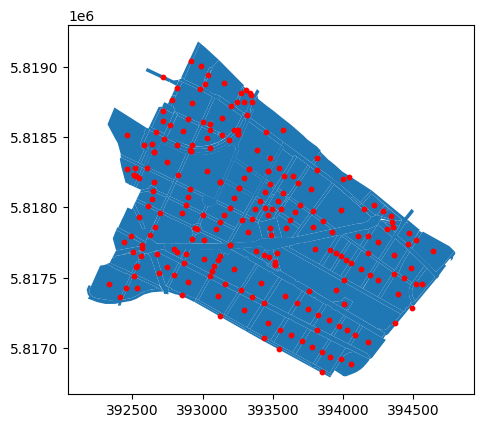

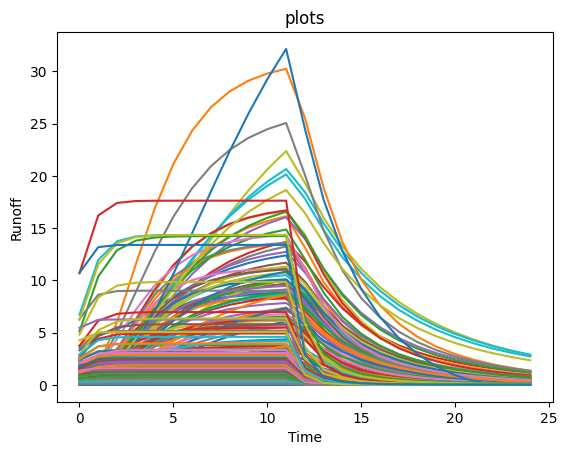

3211.1689999999944 2726.9873999999836
5521 (2727, 3212, 25)
(231, 25)


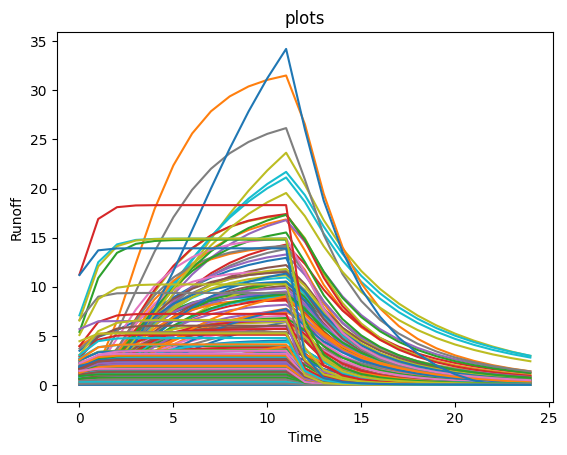

3211.1689999999944 2726.9873999999836
5524 (2727, 3212, 25)
/home/sirui/INNOMAUS/data/val/135mm
Name 135mm
current_time 0
pre_current 11.241062


/tmp/ipykernel_306032/3191557822.py:11: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(x, y, array, kind='linear')
/tmp/ipykernel_306032/3191557822.py:12: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for

h_current 0.5386323238767814
qx_current 0.0037197858459183004
qy_current 0.0035485030321549807
current_time 300
pre_current 16.902061
h_current 0.7086886791317615
qx_current 0.7562698139196383
qy_current 0.5012234841514696
current_time 600
pre_current 18.100256
h_current 1.8963856605116758
qx_current 0.8031865418316401
qy_current 0.6111117141544414
current_time 900
pre_current 18.278315
h_current 2.710505937003882
qx_current 0.783241645703257
qy_current 0.6779093778099233
current_time 1200
pre_current 18.304226
h_current 3.145520990211165
qx_current 1.0529702679639557
qy_current 0.6936514375104482
current_time 1500
pre_current 22.357422
h_current 3.1709036311692538
qx_current 0.9184772713680489
qy_current 0.7069807642054358
current_time 1800
pre_current 25.608114
h_current 3.1766019014138003
qx_current 0.8205827106776075
qy_current 0.77371223569523
current_time 2100
pre_current 27.864517
h_current 3.1811316721579654
qx_current 0.9412565599455025
qy_current 0.8301816284979142
current_ti

/home/sirui/miniconda3/envs/py38/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_306032/1808758030.py:98: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


preds_y torch.Size([1, 267, 227, 1, 3])
torch.Size([267, 227, 1])
torch.Size([]) tensor(0.0003)


/tmp/ipykernel_306032/1808758030.py:98: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


preds_y torch.Size([1, 267, 227, 1, 3])
torch.Size([267, 227, 1])
torch.Size([]) tensor(0.0003)


/tmp/ipykernel_306032/1808758030.py:98: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


Done!


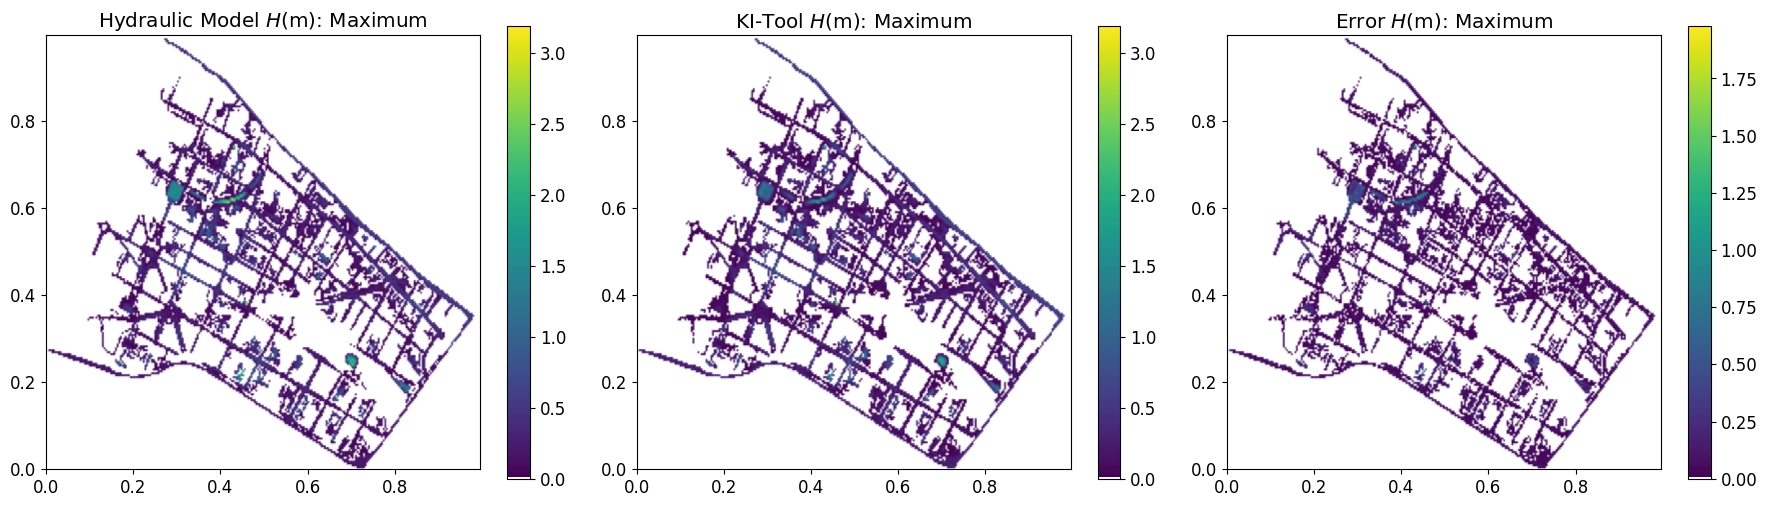

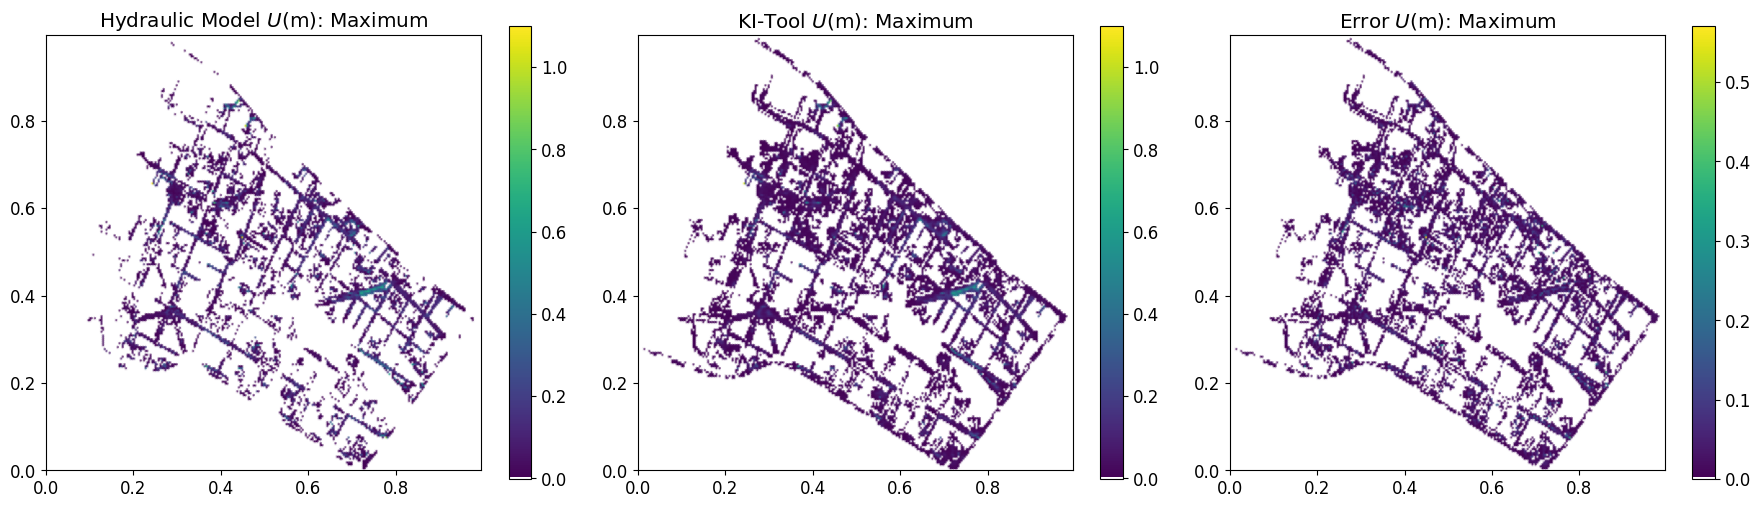

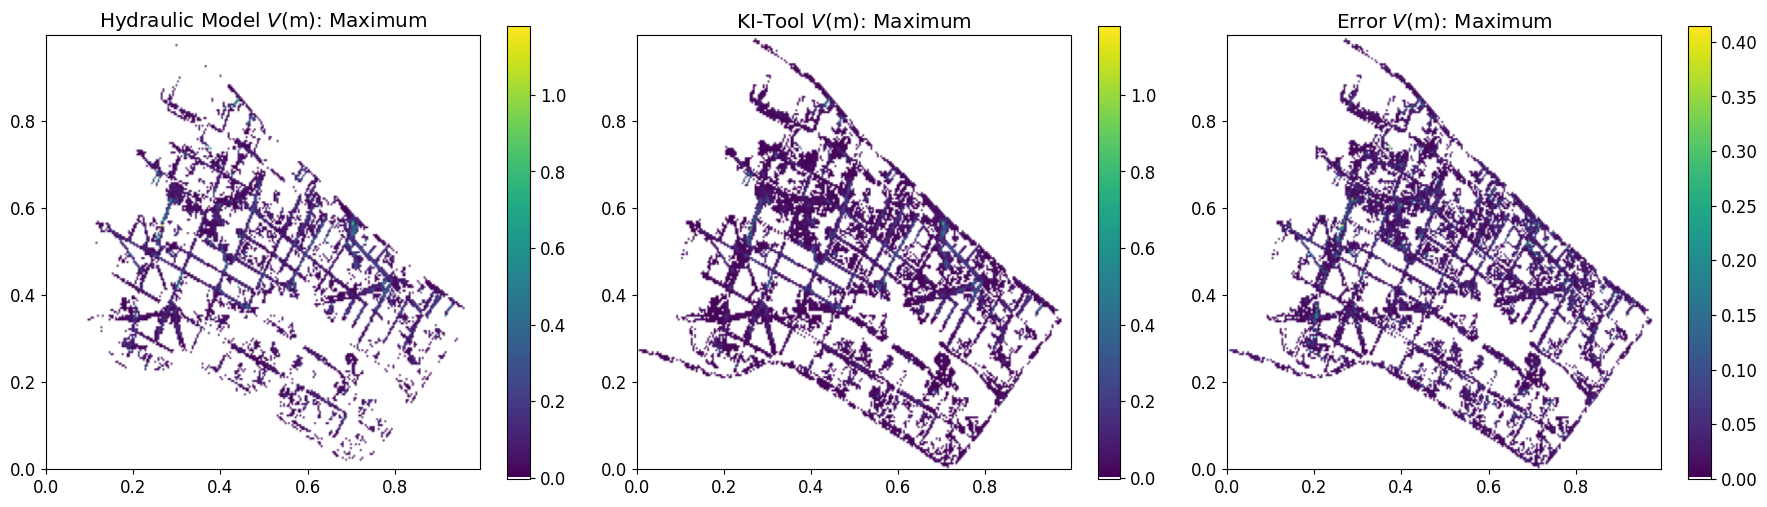

In [7]:
if __name__ == '__main__':
    os.makedirs(Root_path, exist_ok=True)
    #define model
    model = FNN3d(modes1=args.modes1, modes2=args.modes2, modes3=args.modes3, fc_dim=args.fc_dim,
                  layers=args.layers).to(device)
    optimizer = Adam(model.parameters(), betas=(0.9, 0.999), lr=args.base_lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=args.milestones, gamma=args.scheduler_gamma)
    #load model
    PATH = Root_path+'pretrain/checkpoint_799.pth'
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['state_dict'])
    print(checkpoint['state_dict'].keys())
    print('load model sucessfully epoch', checkpoint['epoch'])
    log_dir = Root_path+'model/'
    eval(model, log_dir,runoff_txt_path,inp_file,imput_path_val)  
    print('Done!')